### Итоговое задание Александра Соколова
### по Проекту 8. Возьмёте Бэтмобиль? 
####    Юнит 9. NLP/Computer Vision  (отредактирован 17.02.2021)
---

# 1. Импорты библиотек, инициализация глобальных констант, контроль инициализации пакетов и оборудования
## 1.1. Импорты библиотек

In [1]:
# !pip install -q tensorflow==2.3
!pip install albumentations -q
!pip install pymorphy2
!pip install -U pymorphy2-dicts-ru

     |████████████████████████████████| 55 kB 1.9 MB/s 
     |████████████████████████████████| 8.2 MB 7.1 MB/s 
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13705 sha256=6c843f849c41baa840ba6fc1aecc82b1b163c55bbbae18d3abea4b533a6163d8
  Stored in directory: /root/.cache/pip/wheels/72/b0/3f/1d95f96ff986c7dfffe46ce2be4062f38ebd04b506c77c81b9
Successfully built docopt


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
import PIL
import cv2
import re

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# # keras
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import albumentations

# plt
import matplotlib.pyplot as plt
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
from datetime import datetime as dt
import random as rn
from tensorflow.keras.layers import *
from tensorflow.keras import optimizers
from tensorflow.keras.regularizers import l2
import tensorflow.keras.backend as K
import nltk
from nltk.corpus import stopwords

In [4]:
import pymorphy2
import utils_module06022021_with_gpu as utils

In [5]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.7.9 | packaged by conda-forge | (default, Dec  9 2020, 21:08:20) 
Numpy        : 1.19.5
Tensorflow   : 2.4.1


In [6]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

## 1.2. Глобальные константы

In [7]:
# CURRENT_DIR = './'  # имя текущей директории для локальной машины 
CURRENT_DIR = '../'  # имя текущей директории для каггл

# проверка пути в папке input для корректного назначения глобальной константы PATH_TO_FILE
print(os.listdir(CURRENT_DIR+'input/'))

['sf-dst-car-price-prediction-part2', 'df-after-eda2']


In [8]:
PATH_to_FILE = CURRENT_DIR+'input/sf-dst-car-price-prediction-part2/'  # имя директории с исходными файлами
PATH_to_WORKDIR = CURRENT_DIR+'working/'  # имя рабочей директории

In [9]:
CURRENT_DATE = dt.now().strftime('[%d.%m.%Y]')  # фиксируем текущую дату для контроля версий экспериментов

In [10]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42  # фиксируем состояние генератора псевдо-случайных чисел для воспроизводимости результата
np.random.seed(RANDOM_SEED)
os.environ['PYTHONHASHSEED'] = '0'
rn.seed(RANDOM_SEED)

In [11]:
!pip freeze > requirements.txt

## 1.3. Проверка подключения GPU

In [12]:
# утилита проверяет подключение GPU
utils.check_GPU_ON()

GPU подключен


# 2. Импорт и предобработка данных
## 2.1. Импорт данных

In [13]:
DATA_DIR = PATH_to_FILE
train = pd.read_csv(DATA_DIR + 'train.csv')
test = pd.read_csv(DATA_DIR + 'test.csv')
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')

In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6682 entries, 0 to 6681
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              6682 non-null   object 
 1   brand                 6682 non-null   object 
 2   color                 6682 non-null   object 
 3   description           6682 non-null   object 
 4   engineDisplacement    6682 non-null   object 
 5   enginePower           6682 non-null   object 
 6   fuelType              6682 non-null   object 
 7   mileage               6682 non-null   int64  
 8   modelDate             6682 non-null   int64  
 9   model_info            6682 non-null   object 
 10  name                  6682 non-null   object 
 11  numberOfDoors         6682 non-null   int64  
 12  price                 6682 non-null   float64
 13  productionDate        6682 non-null   int64  
 14  sell_id               6682 non-null   int64  
 15  vehicleConfiguration 

In [15]:
train.nunique()

bodyType                  17
brand                      3
color                     16
description             6147
engineDisplacement        48
enginePower              146
fuelType                   4
mileage                 2900
modelDate                 41
model_info               118
name                     900
numberOfDoors              4
price                   1628
productionDate            38
sell_id                 6682
vehicleConfiguration     288
vehicleTransmission        4
Владельцы                  3
Владение                 173
ПТС                        2
Привод                     3
Руль                       2
dtype: int64

# 3. Model 1: Создадим "наивную" модель 
Эта модель будет предсказывать среднюю цену по модели и году выпуска. 
C ней будем сравнивать другие модели.



In [16]:
# split данных
data_train, data_test = train_test_split(train, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [17]:
# Наивная модель
predicts = []
for index, row in pd.DataFrame(data_test[['model_info', 'productionDate']]).iterrows():
    query = f"model_info == '{row[0]}' and productionDate == '{row[1]}'"
    predicts.append(data_train.query(query)['price'].median())

# заполним не найденные совпадения
predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())

# округлим
predicts = (predicts // 1000) * 1000

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(data_test['price'], predicts.values[:, 0]))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 19.88%


# 4. EDA

In [18]:
df3 = pd.read_csv('../input/df-after-eda2/df2.csv')

pd.set_option('display.max_columns', None)
print('Размерность преобработанного датасета: ', df3.shape)


Размерность преобработанного датасета:  (8177, 75)


In [19]:
df3.head()

,mileage,engineDisplacement2,engDisp_AUDI,engDisp_AUDI_log,engDisp_MERC,engDisp_MERC_log,engDisp_BMW,engDisp_BMW_log,enginePower2,enginePower2_log,Владельцы,modelDate2,productionDate2,productionDate2_log,count_words_d,mean_c_w,sum_c_w,tax,intens_of_expl,bodyType,brand,color,fuelType,model_info,vehicleTransmission,ПТС,Привод,name2,name3,numberOfDoors,tax_cat,mileage_cat,productionDate2_cat,5G-TRONIC,compact,Extra,BlueEFFICIENCY,Long,Package,xDrive,sDrive,S,Brabus,GT,Edition,Kompressor,4MATIC,All-Terrain,9G-TRONIC,4x4,HYBRID,L1,L2,L3,5-speed,TDI,TFSI,CDI,BlueTEC,AMG,3month,6month,c_p_des1,m_s_w_des2,r_l_s_des3,abs_des4,c_c_des5,a_w_des6,r_v_c_des7,intens_of_expl_out,description,price,price_log,Train,sell_id
0,245000,0.389831,0.166667,0.317394,0.346939,0.535307,0.389831,0.648598,272,5.605802,3,13,14,2.639057,45,0.001210,45,40800,15312.500000,седан,BMW,чёрный,бензин,5ER,автоматическая,Оригинал,полный,empty,530xi,4,8,300,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,Авто на бодром ходу. Все работает отлично. П...,599000.0,13.303017,1,1099980990
1,183000,0.355932,0.333333,0.526456,0.346939,0.535307,0.355932,0.617849,204,5.318120,2,9,10,2.302585,57,0.001317,49,13260,15250.000000,седан,AUDI,серебристый,бензин,A6,вариатор,Оригинал,передний,empty,2.8,4,6,300,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,"Продажа от собственника, второй владелец, ПТС ...",850000.0,13.652992,1,1095836906
2,122733,0.474576,0.166667,0.317394,0.448980,0.633983,0.355932,0.617849,306,5.723585,3,11,8,2.079442,144,0.003441,128,45900,12273.300000,седан,MERCEDES,чёрный,бензин,E_KLASSE,автоматическая,Оригинал,полный,empty,350,4,8,300,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,Внимание! Только для клиентов AVILON Автомобил...,1325000.0,14.096923,1,1100195530
3,151000,0.220339,0.166667,0.317394,0.346939,0.535307,0.355932,0.617849,180,5.192957,3,9,10,2.302585,33,0.000806,30,9900,12583.333333,седан,AUDI,белый,бензин,A6,вариатор,Оригинал,передний,empty,2.0,4,5,300,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,В комплекте зимние колёса. 27.07.2020 Замена п...,815000.0,13.610943,1,1099880662
4,140000,0.186441,0.125000,0.251930,0.346939,0.535307,0.355932,0.617849,160,5.075174,3,13,10,2.302585,166,0.003952,147,7200,11666.666667,лифтбек,AUDI,белый,бензин,A5,вариатор,Оригинал,передний,empty,1.8,5,4,300,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,"Отличный авто, 2011 года выпуска, кроме передн...",810000.0,13.604790,1,1083244610


In [20]:
df3_cols= pd.read_csv('../input/df-after-eda2/df2_cols.csv')
cat_cols=df3_cols['cat_cols'][0].split(',')
num_cols = df3_cols['num_cols'][0].split(',')
servis_cols = df3_cols['servis_cols'][0].split(',')
bin_cols = df3_cols['bin_cols'][0].split(',')
target_col= df3_cols['target_col'][0].split(',')
text_cols= df3_cols['text_cols'][0].split(',')

In [21]:
df3['modelDate2_log']=df3['modelDate2'].apply(lambda x: np.log(x))
num_cols.append('modelDate2_log')
'engineDisplacement2'
df3['engineDisplacement2_log']=df3['engineDisplacement2'].apply(lambda x: np.log(x+1))
num_cols.append('engineDisplacement2_log')

# PreProc Tabular Data

In [22]:
#используем категориальные признаки
categorical_features = [
    'bodyType',
    'brand',
    'color',
    'fuelType',
    'model_info',
    'vehicleTransmission',
    'ПТС',
    'Привод',
#     'name2',
    'name3',
#     'numberOfDoors',
    'Владельцы',
#      'tax_cat',
#      'mileage_cat',
#      'productionDate2_cat'
]


#используем числовые признаки
numerical_features = [   
    'mileage',
#     'engineDisplacement2',
#     'engineDisplacement2_log',
#     'engDisp_AUDI',
    'engDisp_AUDI_log',
#     'engDisp_MERC',
    'engDisp_MERC_log',
#     'engDisp_BMW',
    'engDisp_BMW_log',
#     'enginePower2',
    'enginePower2_log',
#     'Владельцы',
    'modelDate2',
#     'modelDate2_log',
#     'productionDate2',
    'productionDate2_log',
#     'count_words_d',
#     'mean_c_w',
#     'sum_c_w',
#     'tax',
#     'intens_of_expl'
]

bin_features = [
    '5G-TRONIC',
    'compact',
    'Extra',
    'BlueEFFICIENCY',
    'Long',
    'Package',
    'xDrive',
    'sDrive',
    'S ',
    'Brabus',
    'GT',
    'Edition',
    'Kompressor',
    '4MATIC',
    'All-Terrain',
    '9G-TRONIC',
    '4x4',
    'HYBRID',
    'L1',
    'L2',
    'L3',
    '5-speed',
    'TDI',
    'TFSI',
    'CDI',
    'BlueTEC',
    'AMG',
    '3month',
    '6month',
    'c_p_des1',
    'm_s_w_des2',
    'r_l_s_des3',
    'abs_des4',
    'c_c_des5',
    'a_w_des6',
    'r_v_c_des7',
    'intens_of_expl_out'
]

In [23]:
data = df3.copy()
data['sample']=data['Train']

In [24]:
def preproc_data(df_input,d_all_cols):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    
    
 
    
    # ################### Categorical Features ############################################################## 
    # Label Encoding
    for column in categorical_features:
        df_output[column] = df_output[column].astype('category').cat.codes
    was_cols = list(df_output.columns)
      
    # One-Hot Encoding: в pandas есть готовая функция - get_dummies.
    df_output = pd.get_dummies(df_output, columns=categorical_features, dummy_na=False)
    new_cols = list(df_output.columns)
    
    dumm_cols =[]
    for col in new_cols:
        
        if col not in was_cols:
            dumm_cols.append(col)
            
   
    
    return df_output[d_all_cols+dumm_cols]

In [25]:
all_cols = numerical_features + bin_features + ['sample'] + ['price_log']

In [26]:
# Запускаем и проверяем, что получилось
df_preproc = preproc_data(data, all_cols)
df_preproc.sample(10)

,mileage,engDisp_AUDI_log,engDisp_MERC_log,engDisp_BMW_log,enginePower2_log,modelDate2,productionDate2_log,5G-TRONIC,compact,Extra,BlueEFFICIENCY,Long,Package,xDrive,sDrive,S,Brabus,GT,Edition,Kompressor,4MATIC,All-Terrain,9G-TRONIC,4x4,HYBRID,L1,L2,L3,5-speed,TDI,TFSI,CDI,BlueTEC,AMG,3month,6month,c_p_des1,m_s_w_des2,r_l_s_des3,abs_des4,c_c_des5,a_w_des6,r_v_c_des7,intens_of_expl_out,sample,price_log,bodyType_0,bodyType_1,bodyType_2,bodyType_3,bodyType_4,bodyType_5,bodyType_6,bodyType_7,bodyType_8,bodyType_9,bodyType_10,bodyType_11,bodyType_12,bodyType_13,brand_0,brand_1,brand_2,color_0,color_1,color_2,color_3,color_4,color_5,color_6,color_7,color_8,color_9,color_10,color_11,color_12,color_13,color_14,fuelType_0,fuelType_1,fuelType_2,fuelType_3,model_info_0,model_info_1,model_info_2,model_info_3,model_info_4,model_info_5,model_info_6,model_info_7,model_info_8,model_info_9,model_info_10,model_info_11,model_info_12,model_info_13,model_info_14,model_info_15,model_info_16,model_info_17,model_info_18,model_info_19,model_info_20,model_info_21,model_info_22,model_info_23,model_info_24,model_info_25,model_info_26,model_info_27,model_info_28,model_info_29,model_info_30,model_info_31,model_info_32,model_info_33,model_info_34,model_info_35,model_info_36,model_info_37,model_info_38,model_info_39,model_info_40,model_info_41,model_info_42,model_info_43,model_info_44,model_info_45,model_info_46,model_info_47,model_info_48,model_info_49,model_info_50,model_info_51,model_info_52,model_info_53,model_info_54,model_info_55,model_info_56,model_info_57,model_info_58,model_info_59,model_info_60,model_info_61,model_info_62,model_info_63,model_info_64,model_info_65,model_info_66,model_info_67,model_info_68,model_info_69,model_info_70,model_info_71,model_info_72,model_info_73,model_info_74,model_info_75,model_info_76,model_info_77,model_info_78,model_info_79,model_info_80,model_info_81,model_info_82,model_info_83,model_info_84,model_info_85,model_info_86,model_info_87,model_info_88,model_info_89,model_info_90,model_info_91,model_info_92,model_info_93,model_info_94,model_info_95,model_info_96,model_info_97,model_info_98,model_info_99,model_info_100,vehicleTransmission_0,vehicleTransmission_1,vehicleTransmission_2,vehicleTransmission_3,ПТС_0,ПТС_1,Привод_0,Привод_1,Привод_2,name3_0,name3_1,name3_2,name3_3,name3_4,name3_5,name3_6,name3_7,name3_8,name3_9,name3_10,name3_11,name3_12,name3_13,name3_14,name3_15,name3_16,name3_17,name3_18,name3_19,name3_20,name3_21,name3_22,name3_23,name3_24,name3_25,name3_26,name3_27,name3_28,name3_29,name3_30,name3_31,name3_32,name3_33,name3_34,name3_35,name3_36,name3_37,name3_38,name3_39,name3_40,name3_41,name3_42,name3_43,name3_44,name3_45,name3_46,name3_47,name3_48,name3_49,name3_50,name3_51,name3_52,name3_53,name3_54,name3_55,name3_56,name3_57,name3_58,name3_59,name3_60,name3_61,name3_62,name3_63,name3_64,name3_65,name3_66,name3_67,name3_68,name3_69,name3_70,name3_71,name3_72,name3_73,name3_74,name3_75,name3_76,name3_77,name3_78,name3_79,name3_80,name3_81,name3_82,name3_83,name3_84,name3_85,name3_86,name3_87,name3_88,name3_89,name3_90,name3_91,name3_92,name3_93,name3_94,name3_95,name3_96,name3_97,name3_98,name3_99,name3_100,name3_101,name3_102,name3_103,name3_104,name3_105,name3_106,name3_107,name3_108,name3_109,name3_110,name3_111,name3_112,name3_113,name3_114,name3_115,name3_116,name3_117,name3_118,name3_119,name3_120,name3_121,name3_122,name3_123,name3_124,name3_125,name3_126,name3_127,name3_128,name3_129,name3_130,name3_131,name3_132,name3_133,name3_134,name3_135,name3_136,name3_137,name3_138,name3_139,name3_140,name3_141,name3_142,name3_143,name3_144,name3_145,name3_146,name3_147,name3_148,name3_149,name3_150,name3_151,name3_152,name3_153,name3_154,name3_155,name3_156,name3_157,name3_158,name3_159,name3_160,name3_161,name3_162,name3_163,name3_164,name3_165,name3_166,name3_167,name3_168,name3_169,name3_170,name3_171,name3_172,name3_173,name3_174,name3_175,name3_176,name3_177,name3_178,name3_179,name3_180,name3_181,na

In [27]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8177 entries, 0 to 8176
Columns: 392 entries, mileage to Владельцы_2
dtypes: float64(8), int64(38), uint8(346)
memory usage: 5.6 MB


## Split data

In [28]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.price_log.values     # наш таргет
X = train_data.drop(['price_log'], axis=1)
X_sub = test_data.drop(['price_log'], axis=1)

In [29]:
y.shape, X.shape, X_sub.shape

((6506,), (6506, 390), (1671, 390))

In [30]:
X_columns = X.columns

In [31]:
scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)
X_sub = scaler.transform(X_sub)

In [32]:
X.min(), X.max(), X_sub.min(), X_sub.max()

(0.0, 1.0, -0.005369298900498531, 1.8181833057878285)

In [33]:
X = pd.DataFrame(X, columns=X_columns)
X_sub = pd.DataFrame(X_sub, columns=X_columns)

In [34]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1671 entries, 6506 to 8176
Columns: 391 entries, mileage to Владельцы_2
dtypes: float64(8), int64(37), uint8(346)
memory usage: 1.1 MB


# Model 2: CatBoostRegressor

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [36]:
model = CatBoostRegressor(iterations = 10000,
                          #depth=10,
                          #learning_rate = 0.5,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['RMSE', 'MSLE'],
                          od_wait=1000,
                          #task_type='GPU',
                         )
model.fit(X_train, y_train,
         eval_set=(X_test, y_test),
         verbose_eval=100,
         use_best_model=True,
         #plot=True
         )

Learning rate set to 0.015166
0:	learn: 0.0416035	test: 0.0413649	best: 0.0413649 (0)	total: 59.2ms	remaining: 9m 51s
100:	learn: 0.0165110	test: 0.0165705	best: 0.0165705 (100)	total: 453ms	remaining: 44.4s
200:	learn: 0.0116144	test: 0.0116359	best: 0.0116359 (200)	total: 829ms	remaining: 40.4s
300:	learn: 0.0103570	test: 0.0104027	best: 0.0104027 (300)	total: 1.2s	remaining: 38.7s
400:	learn: 0.0098385	test: 0.0099132	best: 0.0099132 (400)	total: 1.56s	remaining: 37.4s
500:	learn: 0.0094896	test: 0.0096143	best: 0.0096143 (500)	total: 1.93s	remaining: 36.6s
600:	learn: 0.0091983	test: 0.0093816	best: 0.0093816 (600)	total: 2.29s	remaining: 35.9s
700:	learn: 0.0089716	test: 0.0092098	best: 0.0092098 (700)	total: 2.64s	remaining: 35.1s
800:	learn: 0.0087125	test: 0.0090139	best: 0.0090139 (800)	total: 3.05s	remaining: 35.1s
900:	learn: 0.0084719	test: 0.0088455	best: 0.0088455 (900)	total: 3.44s	remaining: 34.8s
1000:	learn: 0.0082796	test: 0.0087044	best: 0.0087044 (1000)	total: 3.8s

In [37]:
test_predict_catboost = np.exp(model.predict(X_test))
print(f"TEST mape: {(mape(np.exp(y_test), test_predict_catboost))*100:0.2f}%")

TEST mape: 10.94%


### Submission

In [38]:
sub_predict_catboost = np.exp(model.predict(X_sub))
sample_submission['price'] = sub_predict_catboost
sample_submission.to_csv('catboost_submission.csv', index=False)

In [39]:
sample_submission.head()

,sell_id,price
0,1099427284,4.904661e+05
1,1096405886,2.695713e+06
2,1100195294,6.078921e+05
3,1099827282,4.859947e+05
4,1100076198,2.689448e+06


<AxesSubplot:>

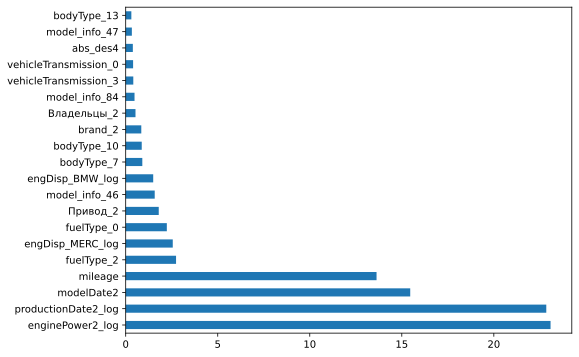

In [40]:
plt.rcParams['figure.figsize'] = (8,6)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')

In [41]:
feat_importances.nsmallest(int(len(X_columns)*0.2))

Brabus           0.000000
GT               0.000000
Edition          0.000000
Kompressor       0.000000
4MATIC           0.000000
                   ...   
name3_67         0.000021
name3_8          0.000022
name3_158        0.000026
name3_22         0.000028
model_info_69    0.000028
Length: 78, dtype: float64

In [42]:
feat_importances.nsmallest(int(len(X_columns)*0.2)).index

Index(['Brabus', 'GT', 'Edition', 'Kompressor', '4MATIC', 'All-Terrain', '4x4',
       '5-speed', 'TDI', 'model_info_28', 'model_info_48', 'model_info_62',
       'model_info_71', 'model_info_72', 'model_info_85', 'model_info_86',
       'model_info_91', 'model_info_98', 'model_info_99', 'name3_3', 'name3_6',
       'name3_10', 'name3_11', 'name3_12', 'name3_20', 'name3_24', 'name3_26',
       'name3_31', 'name3_36', 'name3_42', 'name3_43', 'name3_51', 'name3_55',
       'name3_72', 'name3_78', 'name3_79', 'name3_83', 'name3_87', 'name3_111',
       'name3_120', 'name3_123', 'name3_145', 'name3_154', 'name3_156',
       'name3_157', 'name3_169', 'name3_174', 'name3_176', 'name3_177',
       'name3_184', 'name3_185', 'name3_188', 'name3_189', 'name3_191',
       'name3_192', 'name3_193', 'name3_195', 'name3_196', 'name3_131',
       'name3_128', 'name3_96', 'name3_137', 'name3_7', 'name3_125',
       'bodyType_2', 'name3_179', 'name3_40', 'name3_0', 'name3_182', 'L1',
       'model_info

# Model 3: Tabular NN

Построим обычную сеть:

In [43]:
#используем категориальные признаки
categorical_features = [
    'bodyType',
    'brand',
    'color',
    'fuelType',
    'model_info',
    'vehicleTransmission',
    'ПТС',
    'Привод',
#     'name2',
    'name3',
#     'numberOfDoors',
    'Владельцы',
#      'tax_cat',
#      'mileage_cat',
#      'productionDate2_cat'
]


#используем числовые признаки
numerical_features = [   
    'mileage',
#     'engineDisplacement2',
#     'engineDisplacement2_log',
    'engDisp_AUDI',
#     'engDisp_AUDI_log',
    'engDisp_MERC',
#     'engDisp_MERC_log',
    'engDisp_BMW',
#     'engDisp_BMW_log',
    'enginePower2',
#     'enginePower2_log',
#     'Владельцы',
    'modelDate2',
#     'modelDate2_log',
    'productionDate2',
#     'productionDate2_log',
#     'count_words_d',
#     'mean_c_w',
#     'sum_c_w',
#     'tax',
#     'intens_of_expl'
]

bin_features = [
    '5G-TRONIC',
    'compact',
    'Extra',
    'BlueEFFICIENCY',
    'Long',
    'Package',
    'xDrive',
    'sDrive',
    'S ',
    'Brabus',
    'GT',
    'Edition',
    'Kompressor',
    '4MATIC',
    'All-Terrain',
    '9G-TRONIC',
    '4x4',
    'HYBRID',
    'L1',
    'L2',
    'L3',
    '5-speed',
    'TDI',
    'TFSI',
    'CDI',
    'BlueTEC',
    'AMG',
    '3month',
    '6month',
    'c_p_des1',
    'm_s_w_des2',
    'r_l_s_des3',
    'abs_des4',
    'c_c_des5',
    'a_w_des6',
    'r_v_c_des7',
    'intens_of_expl_out'
]

In [44]:
all_cols = numerical_features + bin_features + ['sample'] + ['price']
df_preproc = preproc_data(data, all_cols)

In [45]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.price.values     # наш таргет
X = train_data.drop(['price'], axis=1)
X_sub = test_data.drop(['price'], axis=1)

In [46]:
y.shape, X.shape, X_sub.shape

((6506,), (6506, 390), (1671, 390))

In [47]:
X_columns = X.columns

In [48]:
scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)
X_sub = scaler.transform(X_sub)

In [49]:
X = pd.DataFrame(X, columns=X_columns)
X_sub = pd.DataFrame(X_sub, columns=X_columns)

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

## Simple Dense NN

In [51]:
num_neurons_l1 = 2*X.shape[1]
num_neurons_l2 = X.shape[1] 

In [52]:
K.clear_session()
model = Sequential()
model.add(L.Dense(num_neurons_l1, input_dim=X_train.shape[1], activation="relu"))
model.add(L.Dropout(0.7))
model.add(L.Dense(num_neurons_l2, activation="relu"))
model.add(L.Dropout(0.7))
model.add(L.Dense(1, activation="linear"))

In [53]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 780)               304980    
_________________________________________________________________
dropout (Dropout)            (None, 780)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 390)               304590    
_________________________________________________________________
dropout_1 (Dropout)          (None, 390)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 391       
Total params: 609,961
Trainable params: 609,961
Non-trainable params: 0
_________________________________________________________________


In [54]:
# Compile model
optimizer = tf.keras.optimizers.Adam(lr=0.004, amsgrad=True)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [55]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5' , 
                             monitor=['val_MAPE'], 
                             verbose=0 , 
                             mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', 
                          patience=100, 
                          restore_best_weights=True, 
                          verbose=1)
callbacks_list = [checkpoint, earlystop]

### Fit

In [56]:
history = model.fit(X_train, y_train,
                    batch_size=1024,
                    epochs=2000, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose=0,
                   )

Restoring model weights from the end of the best epoch.
Epoch 01279: early stopping


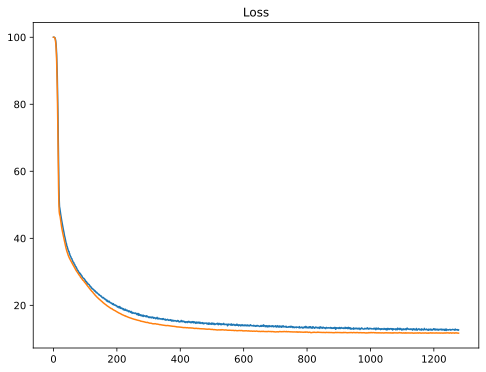

In [57]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [58]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_1.hdf5')

In [59]:
test_predict_nn1 = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_nn1[:,0]))*100:0.2f}%")

TEST mape: 11.70%


In [60]:
sub_predict_nn1 = model.predict(X_sub)
sample_submission['price'] = sub_predict_nn1[:,0]
sample_submission.to_csv('nn1_submission.csv', index=False)

In [61]:
sample_submission.head()

,sell_id,price
0,1099427284,4.190202e+05
1,1096405886,2.632934e+06
2,1100195294,6.264788e+05
3,1099827282,4.850018e+05
4,1100076198,2.722083e+06


Рекомендации для улучшения:    
* В нейросеть желательно подавать данные с распределением, близким к нормальному, поэтому от некоторых числовых признаков имеет смысл взять логарифм перед нормализацией. - done - Как-то наоборот получилось, без логарифмов тут лучше

* Извлечение числовых значений из текста:
Парсинг признаков 'engineDisplacement', 'enginePower', 'Владение' для извлечения числовых значений. - done

* Cокращение размерности категориальных признаков
Признак name 'name' содержит данные, которые уже есть в других столбцах ('enginePower', 'engineDisplacement', 'vehicleTransmission'), поэтому эти данные можно удалить. Затем следует еще сильнее сократить размерность, например, выделив наличие xDrive в качестве отдельного признака. - done

# Model 4: NLP + Multiple Inputs

In [62]:
data.description

0       Авто на бодром ходу.  Все работает отлично.  П...
1       Продажа от собственника, второй владелец, ПТС ...
2       Внимание! Только для клиентов AVILON Автомобил...
3       В комплекте зимние колёса. 27.07.2020 Замена п...
4       Отличный авто, 2011 года выпуска, кроме передн...
                              ...                        
8172    Продаётся любимица семьи. Автомобилем неактивн...
8173    В продаже автомобиль от компании АО ABTODOM, о...
8174    Машина в идеальном техническом состоянии. Обсл...
8175    Автомобиль приобретался новым у дилера Avilon ...
8176    ID: 38887\nКомплектация-Comfort\nГод выпуска в...
Name: description, Length: 8177, dtype: object

In [63]:
nltk.download('stopwords')
stopwords_list = stopwords.words("russian")
# Дополним список СТОП слов (можно добавить любые слова):
stopwords_list.extend(['0', '00', '01', '1', '10', '11', '13', '2', 
                  '2012', '2013', '2014', '2016', '2017', '2018', 
                  '25', '3', '30', '4', '40', '5', '50', '6', '60', '7', '72', '8', '9', 
                  'c', 'fi', 'i', 'in', 'm', 's', '·', 
                  'а', 'б', 'без', 'была', 'быть', 'в', 'в', 'вас', 'ваш', 'во', 
                  'возможна', 'вот', 'все', 'всех', 'вся', 'всё', 'вы', 'г', 'гк', 
                  'год', 'года', 'д', 'для', 'до', 'если', 'есть', 'еще', 'ещё', 'же', 
                  'за', 'и', 'ин', 'й', 'к', 'как', 'км', 'кто', 'л', 'лет', 'лицо', 
                  'м', 'мне', 'могу', 'можете', 'мы', 'на', 'нам', 'наш', 'не', 'ни', 
                  'о', 'ооо', 'от', 'оф', 'по', 'под', 'поехал', 'при', 'р', 'раз', 
                  'руб', 'рублей', 'ряд', 'с', 'себя', 'сел', 'т', 'там', 'тд', 
                  'ти', 'то', 'только', 'тыс', 'у', 'х', 'час', 'что', 'эл', 'это', 
                  'это', 'этого', 'я', 
                  '–', '—', '•', '∙', '●', '☑️', '☛', '✅', '✔', '➥'])

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [64]:
def filter_str(st):
    # Фильтруем стоп-слова в Desrciption:
    split_str = st.split()
    filtered_str = ' '.join((filter(lambda s: s not in stopwords_list, split_str)))
    return filtered_str


data['description2'] = data['description'].apply(filter_str)

In [65]:
data['description2']

0       Авто бодром ходу. Все работает отлично. По эле...
1       Продажа собственника, второй владелец, ПТС ори...
2       Внимание! Только клиентов AVILON Автомобили пр...
3       В комплекте зимние колёса. 27.07.2020 Замена п...
4       Отличный авто, 2011 выпуска, кроме переднего л...
                              ...                        
8172    Продаётся любимица семьи. Автомобилем неактивн...
8173    В продаже автомобиль компании АО ABTODOM, офиц...
8174    Машина идеальном техническом состоянии. Обслуж...
8175    Автомобиль приобретался новым дилера Avilon ок...
8176    ID: 38887 Комплектация-Comfort Год выпуска ПТС...
Name: description2, Length: 8177, dtype: object

In [66]:
def preprocess_text(sen):
    sentence = sen

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ',  sentence)

    return sentence
data['description3'] = data['description2'].apply(preprocess_text)

In [67]:
data['description3']

0       Авто бодром ходу. Все работает отлично. По эле...
1       Продажа собственника, второй владелец, ПТС ори...
2       Внимание! Только клиентов AVILON Автомобили пр...
3       В комплекте зимние колёса. 27.07.2020 Замена п...
4       Отличный авто, 2011 выпуска, кроме переднего л...
                              ...                        
8172    Продаётся любимица семьи. Автомобилем неактивн...
8173    В продаже автомобиль компании АО ABTODOM, офиц...
8174    Машина идеальном техническом состоянии. Обслуж...
8175    Автомобиль приобретался новым дилера Avilon ок...
8176    ID: 38887 Комплектация-Comfort Год выпуска ПТС...
Name: description3, Length: 8177, dtype: object

In [68]:
data['description2']=data['description3']

In [69]:
morph = pymorphy2.MorphAnalyzer()


def filter_str(str):
  # лемматизации текста :
    split_str = str.split()
    filtered_str = ' '.join(
        (map(lambda x: morph.parse(x)[0].normal_form, split_str)))
    return filtered_str


data['description2'] = data['description2'].apply(filter_str)

In [70]:
data['description2']

0       авто бодрый ходу. всё работать отлично. по эле...
1       продажа собственника, второй владелец, птс ори...
2       внимание! только клиент avilon автомобиль проб...
3       в комплект зимний колёса. 27.07.2020 замена пе...
4       отличный авто, 2011 выпуска, кроме передний ле...
                              ...                        
8172    продаваться любимица семьи. автомобиль неактив...
8173    в продажа автомобиль компания ао abtodom, офиц...
8174    машина идеальный технический состоянии. обслуж...
8175    автомобиль приобретаться новый дилер avilon ок...
8176    id: 38887 комплектация-comfort год выпуск птс ...
Name: description2, Length: 8177, dtype: object

In [71]:
# словарь замен частых слов и выражений на коды
dict_replace = {
    'авто':['машина','тачилу','тачка','автомобиль'], 
    'состояние':['состоянии'],
    'дилер':['официальный дилера','оф. дилер','официальный дилер BMW', 'дилер avilon'], 
    'код0':['добрый день'],
    'код1':['хороший состояние','отличный состояние','идеальный состояние'],
    'код2':['а / м'],
    'код3':['автомобиль проходить комплексный'],
    'код4':['более 000 проверять авто пробег гарантия год ждать вы сайт rolf - probeg мобильный приложение мой рольф'],
    'код5':['ваш удобства'],
    'код6':['вентиляция задний сидение'],
    'код7':['все авто проходить'],
    'код8':['гарантия производитель'],
    'код9':['гаражный хранение'],
    'код10':['гарантия юридический чистота'],
    'код11':['доводчик дверей'],
    'код12':['датчик свет датчик дождь'],
    'код13':['камера задний вид"'],
    'код14':['Климат-контроль'],
    'код15':['круиз - контроль','климат - контроль'],
    'код16':['обмен ваш автомобиль'],
    'код17':['подогрев сидение водитель пассажир'],
    'код18':['подушка безопасность водитель'],
    'код19':['подушка безопасность пассажир'],
    'код20':['подушка безопасность'],
    'код21':['птс оригинал'],
    'код22':['рулевой колонка управление'],
    'код23':['сервисный книжка'],
    'код24':['система контроль слепой зона'],
    'код25':['система система курсовой устойчивость'],
    'код26':['широкий ассортимент'],
    'код27':['центральный замок'],
    'код28':['электрорегулировка сидение пассажир'],
    'код29':['avilon авто пробег'],
    'код30':['Mercedes - Benz'],
    
}


In [72]:
for elem in dict_replace:
    for word in dict_replace[elem]:
        data['description2'] = data['description2'].apply(lambda x: x.replace(word, elem))

In [73]:
data['description2']

0       авто бодрый ходу. всё работать отлично. по эле...
1       продажа собственника, второй владелец, код21. ...
2       внимание! только клиент код29 предлагать специ...
3       в комплект зимний колёса. 27.07.2020 замена пе...
4       отличный авто, 2011 выпуска, кроме передний ле...
                              ...                        
8172    продаваться любимица семьи. авто неактивно пол...
8173    в продажа авто компания ао abtodom, официальны...
8174    авто идеальный технический состояние. обслужив...
8175    авто приобретаться новый дилер октябрь года. п...
8176    id: 38887 комплектация-comfort год выпуск птс ...
Name: description2, Length: 8177, dtype: object

In [74]:
data['description'] = data['description2']

In [75]:
# TOKENIZER
# The maximum number of words to be used. (most frequent)
MAX_WORDS = 100000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 256

In [76]:
# split данных
text_train = data.description.iloc[X_train.index]
text_test = data.description.iloc[X_test.index]
text_sub = data.description.iloc[X_sub.index]

### Tokenizer

In [77]:
%%time
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

CPU times: user 1.09 s, sys: 14.4 ms, total: 1.11 s
Wall time: 1.11 s


In [78]:
tokenize.word_index

{'авто': 1,
 'система': 2,
 'задний': 3,
 'салон': 4,
 'пробег': 5,
 'передний': 6,
 'сидение': 7,
 'в': 8,
 'комплект': 9,
 'дилер': 10,
 'кредит': 11,
 'диск': 12,
 'ваш': 13,
 'код1': 14,
 'новый': 15,
 'пакет': 16,
 'фара': 17,
 'официальный': 18,
 'руль': 19,
 'колесо': 20,
 'состояние': 21,
 'обмен': 22,
 'комплектация': 23,
 'вы': 24,
 '000': 25,
 'контроль': 26,
 'bmw': 27,
 'всё': 28,
 'полный': 29,
 'покупка': 30,
 'зеркало': 31,
 'то': 32,
 'продажа': 33,
 'автомобиля': 34,
 'с': 35,
 'шина': 36,
 'два': 37,
 'двигатель': 38,
 'на': 39,
 'любой': 40,
 'обогрев': 41,
 'проверка': 42,
 'обслуживание': 43,
 'технический': 44,
 'резина': 45,
 'по': 46,
 'гарантия': 47,
 'птс': 48,
 'торг': 49,
 'масло': 50,
 'один': 51,
 'условие': 52,
 'замена': 53,
 'владелец': 54,
 'рулевой': 55,
 'кузов': 56,
 'климат': 57,
 'купить': 58,
 'стекло': 59,
 '2': 60,
 'подогрев': 61,
 'оригинальный': 62,
 'дтп': 63,
 'дополнительный': 64,
 'чёрный': 65,
 'электропривод': 66,
 'м': 67,
 'зимний':

In [79]:
%%time
text_train_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
text_test_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)
text_sub_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_sub), maxlen=MAX_SEQUENCE_LENGTH)

print(text_train_sequences.shape, text_test_sequences.shape, text_sub_sequences.shape, )

(5530, 256) (976, 256) (1671, 256)
CPU times: user 1.11 s, sys: 2.28 ms, total: 1.11 s
Wall time: 1.11 s


In [80]:
# вот так теперь выглядит наш текст
print(text_train.iloc[6])
print(text_train_sequences[6])

безопасность: 8. мультимедиа: 4. обзор: 4. комфорт: 7. защита угона: 1. салон: 6.
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0  

### RNN NLP

In [81]:
MAX_SEQUENCE_LENGTH

256

In [82]:
K.clear_session()
model_nlp = Sequential()
model_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
model_nlp.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,))
model_nlp.add(L.LSTM(2*MAX_SEQUENCE_LENGTH, return_sequences=True))
model_nlp.add(L.Dropout(0.6))
model_nlp.add(L.LSTM(MAX_SEQUENCE_LENGTH,))
model_nlp.add(L.Dropout(0.25))
model_nlp.add(L.Dense(MAX_SEQUENCE_LENGTH//2, activation="relu"))
model_nlp.add(L.Dropout(0.25))

### MLP

In [83]:
model_mlp = Sequential()
model_mlp.add(L.Dense(num_neurons_l1, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.7))
model_mlp.add(L.Dense(num_neurons_l2, activation="relu"))
model_mlp.add(L.Dropout(0.7))

### Multiple Inputs NN

In [84]:
combinedInput = L.concatenate([model_nlp.output, model_mlp.output])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_nlp.input, model_mlp.input], outputs=head)

In [85]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_description (InputLayer)    [(None, 256)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 256, 256)     7979520     seq_description[0][0]            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 256, 512)     1574912     embedding[0][0]                  
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 512)     0           lstm[0][0]                       
______________________________________________________________________________________________

### Fit

In [86]:
optimizer = tf.keras.optimizers.Adam(lr=0.006, amsgrad=True)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [87]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', 
                             monitor=['val_MAPE'], 
                             verbose=0, 
                             mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', 
                          patience=20, 
                          restore_best_weights=True, 
                          verbose=1)
callbacks_list = [checkpoint, earlystop]

In [88]:
history = model.fit([text_train_sequences, X_train], y_train,
                    batch_size=1024,
                    epochs=600, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([text_test_sequences, X_test], y_test),
                    callbacks=callbacks_list
                   )

Epoch 1/600
6/6 [==============================] - 11s 1s/step - loss: 99.9998 - MAPE: 99.9998 - val_loss: 99.9978 - val_MAPE: 99.9978
Epoch 2/600
6/6 [==============================] - 5s 892ms/step - loss: 99.9930 - MAPE: 99.9930 - val_loss: 99.9384 - val_MAPE: 99.9384
Epoch 3/600
6/6 [==============================] - 5s 828ms/step - loss: 99.8800 - MAPE: 99.8800 - val_loss: 99.4265 - val_MAPE: 99.4265
Epoch 4/600
6/6 [==============================] - 5s 835ms/step - loss: 99.1322 - MAPE: 99.1322 - val_loss: 97.1274 - val_MAPE: 97.1274
Epoch 5/600
6/6 [==============================] - 5s 816ms/step - loss: 96.1209 - MAPE: 96.1209 - val_loss: 89.8410 - val_MAPE: 89.8410
Epoch 6/600
6/6 [==============================] - 5s 818ms/step - loss: 87.3185 - MAPE: 87.3185 - val_loss: 71.2687 - val_MAPE: 71.2687
Epoch 7/600
6/6 [==============================] - 5s 832ms/step - loss: 66.6236 - MAPE: 66.6236 - val_loss: 48.5125 - val_MAPE: 48.5125
Epoch 8/600
6/6 [==========================

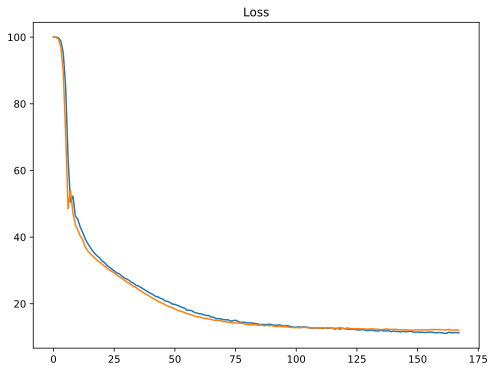

In [89]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [90]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_mlp_nlp.hdf5')

In [91]:
test_predict_nn2 = model.predict([text_test_sequences, X_test])
print(f"TEST mape: {(mape(y_test, test_predict_nn2[:,0]))*100:0.2f}%")

TEST mape: 12.09%


In [92]:
sub_predict_nn2 = model.predict([text_sub_sequences, X_sub])
sample_submission['price'] = sub_predict_nn2[:,0]
sample_submission.to_csv('nn2_submission.csv', index=False)

In [93]:
sample_submission.head()

,sell_id,price
0,1099427284,3.969274e+05
1,1096405886,2.595969e+06
2,1100195294,5.889148e+05
3,1099827282,4.531241e+05
4,1100076198,2.709482e+06


Идеи для улучшения NLP части:
* Выделить из описаний часто встречающиеся блоки текста, заменив их на кодовые слова или удалив - done
* Сделать предобработку текста, например, сделать лемматизацию - done
* Поработать над алгоритмами очистки и аугментации текста - done

# Model 5: Добавляем картинки

### Data

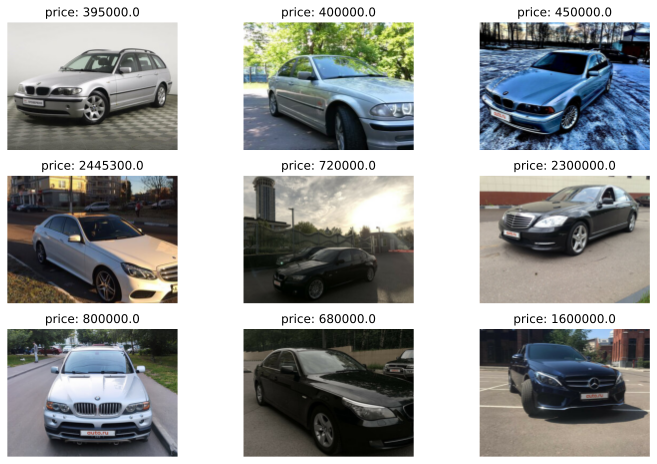

In [94]:
# убедимся, что цены и фото подгрузились верно
plt.figure(figsize = (12,8))

random_image = train.sample(n = 9)
random_image_paths = random_image['sell_id'].values
random_image_cat = random_image['price'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(DATA_DIR+'img/img/' + str(path) + '.jpg')
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('price: ' + str(random_image_cat[index]))
    plt.axis('off')
plt.show()

In [95]:
size = (320, 240)

def get_image_array(index):
    images_train = []
    for index, sell_id in enumerate(data['sell_id'].iloc[index].values):
        image = cv2.imread(DATA_DIR + 'img/img/' + str(sell_id) + '.jpg')
        assert(image is not None)
        image = cv2.resize(image, size)
        images_train.append(image)
    images_train = np.array(images_train)
    print('images shape', images_train.shape, 'dtype', images_train.dtype)
    return(images_train)

images_train = get_image_array(X_train.index)
images_test = get_image_array(X_test.index)
images_sub = get_image_array(X_sub.index)

images shape (5530, 240, 320, 3) dtype uint8
images shape (976, 240, 320, 3) dtype uint8
images shape (1671, 240, 320, 3) dtype uint8


### albumentations

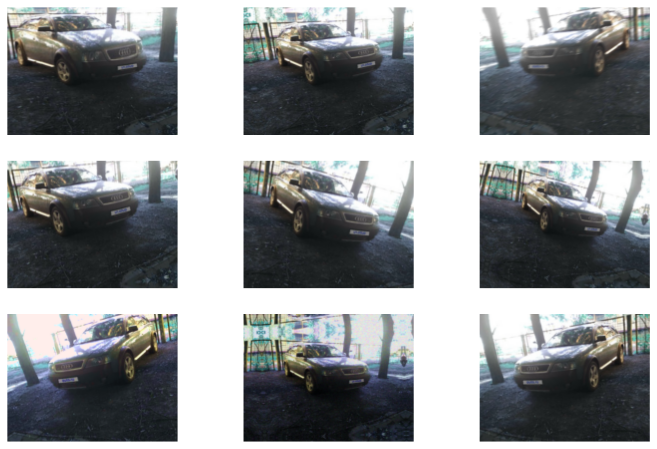

In [96]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)


#пример взят из официальной документации: https://albumentations.readthedocs.io/en/latest/examples.html
augmentation = Compose([
    HorizontalFlip(),
    OneOf([
        IAAAdditiveGaussianNoise(),
        GaussNoise(),
    ], p=0.2),
    OneOf([
        MotionBlur(p=0.2),
        MedianBlur(blur_limit=3, p=0.1),
        Blur(blur_limit=3, p=0.1),
    ], p=0.2),
    ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=1),
    OneOf([
        OpticalDistortion(p=0.3),
        GridDistortion(p=0.1),
        IAAPiecewiseAffine(p=0.3),
    ], p=0.2),
    OneOf([
        CLAHE(clip_limit=2),
        IAASharpen(),
        IAAEmboss(),
        RandomBrightnessContrast(),
    ], p=0.3),
    HueSaturationValue(p=0.3),
], p=1)

#пример
plt.figure(figsize = (12,8))
for i in range(9):
    img = augmentation(image = images_train[0])['image']
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

## tf.data.Dataset
Если все изображения мы будем хранить в памяти, то может возникнуть проблема ее нехватки. Не храните все изображения в памяти целиком!

Метод .fit() модели keras может принимать либо данные в виде массивов или тензоров, либо разного рода итераторы, из которых наиболее современным и гибким является [tf.data.Dataset](https://www.tensorflow.org/guide/data). Он представляет собой конвейер, то есть мы указываем, откуда берем данные и какую цепочку преобразований с ними выполняем. Далее мы будем работать с tf.data.Dataset.

Dataset хранит информацию о конечном или бесконечном наборе кортежей (tuple) с данными и может возвращать эти наборы по очереди. Например, данными могут быть пары (input, target) для обучения нейросети. С данными можно осуществлять преобразования, которые осуществляются по мере необходимости ([lazy evaluation](https://ru.wikipedia.org/wiki/%D0%9B%D0%B5%D0%BD%D0%B8%D0%B2%D1%8B%D0%B5_%D0%B2%D1%8B%D1%87%D0%B8%D1%81%D0%BB%D0%B5%D0%BD%D0%B8%D1%8F)).

`tf.data.Dataset.from_tensor_slices(data)` - создает датасет из данных, которые представляют собой либо массив, либо кортеж из массивов. Деление осуществляется по первому индексу каждого массива. Например, если `data = (np.zeros((128, 256, 256)), np.zeros(128))`, то датасет будет содержать 128 элементов, каждый из которых содержит один массив 256x256 и одно число.

`dataset2 = dataset1.map(func)` - применение функции к датасету; функция должна принимать столько аргументов, каков размер кортежа в датасете 1 и возвращать столько, сколько нужно иметь в датасете 2. Пусть, например, датасет содержит изображения и метки, а нам нужно создать датасет только из изображений, тогда мы напишем так: `dataset2 = dataset.map(lambda img, label: img)`.

`dataset2 = dataset1.batch(8)` - группировка по батчам; если датасет 2 должен вернуть один элемент, то он берет из датасета 1 восемь элементов, склеивает их (нулевой индекс результата - номер элемента) и возвращает.

`dataset.__iter__()` - превращение датасета в итератор, из которого можно получать элементы методом `.__next__()`. Итератор, в отличие от самого датасета, хранит позицию текущего элемента. Можно также перебирать датасет циклом for.

`dataset2 = dataset1.repeat(X)` - датасет 2 будет повторять датасет 1 X раз.

Если нам нужно взять из датасета 1000 элементов и использовать их как тестовые, а остальные как обучающие, то мы напишем так:

`test_dataset = dataset.take(1000)
train_dataset = dataset.skip(1000)`

Датасет по сути неизменен: такие операции, как map, batch, repeat, take, skip никак не затрагивают оригинальный датасет. Если датасет хранит элементы [1, 2, 3], то выполнив 3 раза подряд функцию dataset.take(1) мы получим 3 новых датасета, каждый из которых вернет число 1. Если же мы выполним функцию dataset.skip(1), мы получим датасет, возвращающий числа [2, 3], но исходный датасет все равно будет возвращать [1, 2, 3] каждый раз, когда мы его перебираем.

tf.Dataset всегда выполняется в graph-режиме (в противоположность eager-режиму), поэтому либо преобразования (`.map()`) должны содержать только tensorflow-функции, либо мы должны использовать tf.py_function в качестве обертки для функций, вызываемых в `.map()`. Подробнее можно прочитать [здесь](https://www.tensorflow.org/guide/data#applying_arbitrary_python_logic).

In [97]:
# NLP part
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

In [98]:
def process_image(image):
    return augmentation(image = image.numpy())['image']

def tokenize_(descriptions):
  return sequence.pad_sequences(tokenize.texts_to_sequences(descriptions), maxlen = MAX_SEQUENCE_LENGTH)

def tokenize_text(text):
    return tokenize_([text.numpy().decode('utf-8')])[0]

def tf_process_train_dataset_element(image, table_data, text, price):
    im_shape = image.shape
    [image,] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

def tf_process_val_dataset_element(image, table_data, text, price):
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

train_dataset = tf.data.Dataset.from_tensor_slices((
    images_train, X_train, data.description.iloc[X_train.index], y_train
    )).map(tf_process_train_dataset_element)

test_dataset = tf.data.Dataset.from_tensor_slices((
    images_test, X_test, data.description.iloc[X_test.index], y_test
    )).map(tf_process_val_dataset_element)

y_sub = np.zeros(len(X_sub))
sub_dataset = tf.data.Dataset.from_tensor_slices((
    images_sub, X_sub, data.description.iloc[X_sub.index], y_sub
    )).map(tf_process_val_dataset_element)

#проверяем, что нет ошибок (не будет выброшено исключение):
train_dataset.__iter__().__next__();
test_dataset.__iter__().__next__();
sub_dataset.__iter__().__next__();

### Строим сверточную сеть для анализа изображений без "головы"

In [99]:
K.clear_session()
#нормализация включена в состав модели EfficientNetB3, поэтому на вход она принимает данные типа uint8
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB3(weights = 'imagenet', include_top = False, input_shape = (size[1], size[0], 3))
efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)

43941888/43941136 [==============================] - 0s 0us/step


In [100]:

#строим нейросеть для анализа табличных данных
tabular_model = Sequential([
    L.Input(shape = X.shape[1]),
    L.Dense(num_neurons_l1, activation = 'relu'),
    L.Dropout(0.7),
    L.Dense(num_neurons_l2, activation = 'relu'),
    L.Dropout(0.7),
    ])

In [101]:
# NLP
nlp_model = Sequential([
    L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"),
    L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,),
    L.LSTM(2*MAX_SEQUENCE_LENGTH, return_sequences=True),
    L.Dropout(0.5),
    L.LSTM(MAX_SEQUENCE_LENGTH),
    L.Dropout(0.25),
    L.Dense(MAX_SEQUENCE_LENGTH//2),
    ])

In [102]:
#объединяем выходы трех нейросетей
combinedInput = L.concatenate([efficientnet_output, tabular_model.output, nlp_model.output])

# being our regression head
head = L.Dense(256, activation="relu")(combinedInput)
head = L.Dense(1,)(head)

model = Model(inputs=[efficientnet_model.input, tabular_model.input, nlp_model.input], outputs=head)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 320, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 240, 320, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 240, 320, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 241, 321, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

In [103]:
optimizer = tf.keras.optimizers.Adam(lr=0.006, amsgrad=True)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [104]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True, verbose=1)
callbacks_list = [checkpoint, earlystop]

In [105]:
history = model.fit(train_dataset.batch(30),
                    epochs=100,
                    validation_data = test_dataset.batch(30),
                    callbacks=callbacks_list
                   )

Epoch 1/100
185/185 [==============================] - 173s 842ms/step - loss: 70.9434 - MAPE: 70.9434 - val_loss: 31.9918 - val_MAPE: 31.9918
Epoch 2/100
185/185 [==============================] - 148s 799ms/step - loss: 31.2717 - MAPE: 31.2717 - val_loss: 24.1283 - val_MAPE: 24.1283
Epoch 3/100
185/185 [==============================] - 148s 798ms/step - loss: 23.9981 - MAPE: 23.9981 - val_loss: 19.7937 - val_MAPE: 19.7937
Epoch 4/100
185/185 [==============================] - 146s 788ms/step - loss: 19.7117 - MAPE: 19.7117 - val_loss: 16.8347 - val_MAPE: 16.8347
Epoch 5/100
185/185 [==============================] - 148s 801ms/step - loss: 17.6992 - MAPE: 17.6992 - val_loss: 15.2186 - val_MAPE: 15.2186
Epoch 6/100
185/185 [==============================] - 146s 785ms/step - loss: 16.7367 - MAPE: 16.7367 - val_loss: 14.8103 - val_MAPE: 14.8103
Epoch 7/100
185/185 [==============================] - 146s 784ms/step - loss: 15.9289 - MAPE: 15.9289 - val_loss: 14.0088 - val_MAPE: 14.0088

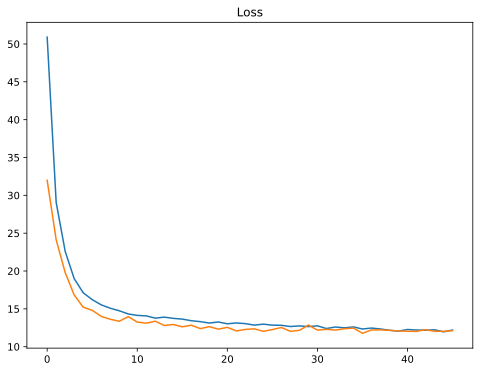

In [106]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [107]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_final.hdf5')

In [108]:
test_predict_nn3 = model.predict(test_dataset.batch(30))
print(f"TEST mape: {(mape(y_test, test_predict_nn3[:,0]))*100:0.2f}%")

TEST mape: 12.12%


In [109]:
sub_predict_nn3 = model.predict(sub_dataset.batch(30))
sample_submission['price'] = sub_predict_nn3[:,0]
sample_submission.to_csv('nn3_submission.csv', index=False)

In [110]:
sample_submission.head()

,sell_id,price
0,1099427284,4.084581e+05
1,1096405886,2.622256e+06
2,1100195294,5.967726e+05
3,1099827282,5.262025e+05
4,1100076198,2.829383e+06


были экперименты с B4,B6 с Fine_Tuning и LR-circle, но прироста не было

# Blend

In [111]:
blend_predict = (test_predict_catboost + test_predict_nn2[:,0]) / 2
print(f"TEST mape: {(mape(y_test, blend_predict))*100:0.2f}%")

TEST mape: 10.83%


In [112]:
blend_sub_predict = (sub_predict_catboost + sub_predict_nn2[:,0]) / 2
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv('blend_submission.csv', index=False)

In [113]:
sample_submission.head()

,sell_id,price
0,1099427284,4.436967e+05
1,1096405886,2.645841e+06
2,1100195294,5.984034e+05
3,1099827282,4.695594e+05
4,1100076198,2.699465e+06


# Model Bonus: проброс признака

In [114]:
K.clear_session()
# MLP
model_mlp = Sequential()
model_mlp.add(L.Dense(num_neurons_l1, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.7))
model_mlp.add(L.Dense(num_neurons_l2, activation="relu"))
model_mlp.add(L.Dropout(0.7))

In [115]:
# FEATURE Input
# Iput
productiondate = L.Input(shape=[1], name="productionDate2")
# Embeddings layers
emb_productiondate = L.Embedding(len(X.productionDate2.unique().tolist())+1, 20)(productiondate)
f_productiondate = L.Flatten()(emb_productiondate)

In [116]:
combinedInput = L.concatenate([model_mlp.output, f_productiondate,])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_mlp.input, productiondate], outputs=head)

In [117]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dense_input (InputLayer)        [(None, 390)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 780)          304980      dense_input[0][0]                
__________________________________________________________________________________________________
dropout (Dropout)               (None, 780)          0           dense[0][0]                      
__________________________________________________________________________________________________
productionDate2 (InputLayer)    [(None, 1)]          0                                            
______________________________________________________________________________________________

In [118]:
optimizer = tf.keras.optimizers.Adam(lr=0.006, amsgrad=True)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [119]:
history = model.fit([X_train, X_train.productionDate2.values], y_train,
                    batch_size=1024,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([X_test, X_test.productionDate2.values], y_test),
                    callbacks=callbacks_list
                   )

Epoch 1/500
6/6 [==============================] - 1s 74ms/step - loss: 99.9999 - MAPE: 99.9999 - val_loss: 99.9981 - val_MAPE: 99.9981
Epoch 2/500
6/6 [==============================] - 0s 18ms/step - loss: 99.9941 - MAPE: 99.9941 - val_loss: 99.9498 - val_MAPE: 99.9498
Epoch 3/500
6/6 [==============================] - 0s 26ms/step - loss: 99.9027 - MAPE: 99.9027 - val_loss: 99.5300 - val_MAPE: 99.5300
Epoch 4/500
6/6 [==============================] - 0s 20ms/step - loss: 99.2837 - MAPE: 99.2837 - val_loss: 97.6134 - val_MAPE: 97.6134
Epoch 5/500
6/6 [==============================] - 0s 21ms/step - loss: 96.7698 - MAPE: 96.7698 - val_loss: 91.4374 - val_MAPE: 91.4374
Epoch 6/500
6/6 [==============================] - 0s 14ms/step - loss: 89.2448 - MAPE: 89.2448 - val_loss: 75.4584 - val_MAPE: 75.4584
Epoch 7/500
6/6 [==============================] - 0s 14ms/step - loss: 71.2094 - MAPE: 71.2094 - val_loss: 50.3983 - val_MAPE: 50.3983
Epoch 8/500
6/6 [==============================]

In [120]:
model.load_weights('../working/best_model.hdf5')
test_predict_nn_bonus = model.predict([X_test, X_test.productionDate2.values])
print(f"TEST mape: {(mape(y_test, test_predict_nn_bonus[:,0]))*100:0.2f}%")

TEST mape: 12.06%


# Model: Blending с весами и поиск оптимума

In [121]:
test_predict_catboost.shape, test_predict_nn1.shape, test_predict_nn2.shape, test_predict_nn3.shape

((976,), (976, 1), (976, 1), (976, 1))

In [122]:
min_MAPE = 100.0
N = 20
c = round(1/N,3)
opti_c = []
for i in range(N):
    lc1 = round(1 - c*i,2)
    for j in range(N-i):
        lc2 = round(lc1- c*j,2)
        for k in range (N-i-j):
            lc3 = round(lc2- c*k,2)
            c1 = c*i
            c2 = c*j
            c3 = c*k
            blend_predict = (c1*test_predict_catboost \
                           + c2*test_predict_nn1[:,0] \
                           + c3*test_predict_nn2[:,0] \
                           + lc3*test_predict_nn3[:,0] )
            temp_mape = mape(y_test, blend_predict)*100
            if temp_mape<min_MAPE:
                min_MAPE = temp_mape
                opti_c = [c1,c2,c3,lc3]
print(min_MAPE, opti_c)

10.683003987047824 [0.65, 0.30000000000000004, 0.0, 0.05]


In [123]:
sub_predict_catboost.shape, sub_predict_nn1.shape, sub_predict_nn2.shape, sub_predict_nn3.shape

((1671,), (1671, 1), (1671, 1), (1671, 1))

In [124]:
c1 = opti_c[0]
c2 = opti_c[1]
c3 = opti_c[2]
lc3 = opti_c[3]
blend_sub_predict = (c1*sub_predict_catboost \
                   + c2*sub_predict_nn1[:,0] \
                   + c3*sub_predict_nn2[:,0] \
                   + lc3*sub_predict_nn3[:,0])
    
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv('blend_submission2.csv', index=False)

In [125]:
sample_submission.head()

,sell_id,price
0,1099427284,4.649319e+05
1,1096405886,2.673206e+06
2,1100195294,6.129121e+05
3,1099827282,4.877072e+05
4,1100076198,2.706236e+06


### Результаты:  
- score на kaggle = 11.11494 (5 место)
- проект выполнен в двух ноутбуках:
  - [ноутбук с EDA и препроцессингом табличных данных](https://www.kaggle.com/sokolovaleks/sf-dst-10-car-price-predic-part2-EDA-sokolov). Результатом этого ноутбука является датасет, который используется этим (основным) ноутбуком.


К сожалению не хватило времени, чтобы:
- проанализировать где ошибается модель
- в ручную собрать тест, чтобы учесть несбалансированные гибриды и электрокары или отдельно обучить на них модели и сделать блендинг
- составить таблицу с результатами экспериментов как это было в предыдущем проекте
- перебрать все варианты комбинаций признаков для оптимального набора для catboost